# CREDIT WHERE CREDIT IS DUE!
*THIS NOTEBOOK WAS CREATED INITIALLY BY STEVE RACKOVIC ON KAGGLE!*

*ALL OUTPUTS (E.G. .gpkg FILES) FROM THIS NOTEBOOK MUST REFERENCE STEVO RACKOVIC'S WORK!*

- Original notebook on Kaggle: [Peru Settlements as a Dynamic Graph!](https://www.kaggle.com/code/rackovic1994/peru-settlements-as-a-dynamic-graph)
- Original notebook author: [Stevo Rackovic](https://www.kaggle.com/rackovic1994)

![https://www.meisterdrucke.uk/kunstwerke/1260px/American%20School%20-%20Caripuna%20Indians%20with%20tapir%20from%20The%20Amazon%20and%20Madeira%20Rivers%20by%20Franz%20Keller%201874%20%20-%20%28MeisterDrucke-80644%29.jpg](http://www.meisterdrucke.uk/kunstwerke/1260px/American%20School%20-%20Caripuna%20Indians%20with%20tapir%20from%20The%20Amazon%20and%20Madeira%20Rivers%20by%20Franz%20Keller%201874%20%20-%20%28MeisterDrucke-80644%29.jpg)

# Settlements Progression

Human movements and settlement locations are not random. In order to predict potential historical sites, one could look at the progression of settlements over time. Particualty, I want to build a graph with geo-locations of known sites, and make it dynamic, showing the new settlements, and removing the abandoned ones, with connections between proximal pairs.

For this, I will start by scraping wikipedia links within relevant categories. 

In [3]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import time
import numpy as np
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import great_circle
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

# Base URL for Wikipedia
BASE_URL = "https://en.wikipedia.org"

### Scraping Archeological Sites of Peru

Let's start with Peru region, and scrape the wikipedia links available in this category:

[https://en.wikipedia.org/wiki/List_of_archaeological_sites_in_Peru](https://en.wikipedia.org/wiki/List_of_archaeological_sites_in_Peru)

In [4]:
def get_site_links(category_url:str) -> list:
    """
    Extracts links from the provided wikipedia category.

    -------
    :param category_url: url pointing to the wikipedia list of relevant sites

    -------
    :returns: List of urls corresponding to the liked wikipedia pages within the category
    """
    response = requests.get(category_url)
    soup = BeautifulSoup(response.text, "html.parser")
    site_links = []

    content_div = soup.find("div", {"class": "mw-parser-output"})
    if content_div:
        for ul in content_div.find_all("ul"):
            for li in ul.find_all("li"):
                a_tag = li.find("a")
                if a_tag and a_tag.has_attr("href") and not a_tag['href'].startswith("#"):
                    href = a_tag['href']
                    if href.startswith('http'):
                        full_url = href
                    else:
                        full_url = BASE_URL + a_tag['href']
                    if 'https://en.wikipedia.org/wiki/' in full_url:
                        site_links.append(full_url)
    return site_links

In [5]:
# Category page for Archaeological sites in Peru
CATEGORY_URL = f"{BASE_URL}/wiki/List_of_archaeological_sites_in_Peru"
site_links = get_site_links(CATEGORY_URL)
print(f'Found {len(site_links)} potential links.')
for i in range(10):
    print(site_links[np.random.randint(len(site_links))])

Found 343 potential links.
https://en.wikipedia.org/wiki/List_of_postal_codes_in_Peru
https://en.wikipedia.org/wiki/Khuchi_Mach%27ay
https://en.wikipedia.org/wiki/Quriwayrachina,_La_Convenci%C3%B3n
https://en.wikipedia.org/wiki/Choquequirao
https://en.wikipedia.org/wiki/Puka_Urqu_(Ayacucho)
https://en.wikipedia.org/wiki/Chawaytiri
https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Peru
https://en.wikipedia.org/wiki/Inkapintay
https://en.wikipedia.org/wiki/Huayna_Picchu
https://en.wikipedia.org/wiki/Pumaq_Hirka


For each of these links, we will check if there is a geo-location, i.e., latitude and longitude.
If available, we scrape the data from there.

Besides coordinates, we want to have the foundation and abandonment dates. Often, these info are in the info-box of the wikipedia page. If it is not there, we extract introductory text, and look for potential info there. Wherever there are indicators like 'AD', 'BC', 'years ago', we look if there is a numeric 'word' next to it, and take that as a potential date. Further, if next to it we have words like 'founded' or their synonyms, we take that as an answer. If no clear indicator is found, but there are some potential dates in the text, we simply order them, and take the earliest one for the foundation date, and the latest one (if the list has at least two distinct elements), as the abandonment date.

Finally, if this still didn't yield an answer, we look if the info-box contains a culture field. Then the age of the site is assumed to be the same as the spread of that culture. 

In [6]:
def extract_site_data(url:str) -> dict:
    '''
    Extracts the data about the archeological site. 
    If it can be located precieslly, with geo coordinates.
    Extracts location, and foundataion and abandonment dates. If on of hte later is not available, also extracts intro text and culture info, that can be used to infer the dates. 
        
    -------
    :param url: url pointing to the wikipedia page

    -------
    :returns: Dictionary containing the data about the settlement, extracted from the given url. 
    '''

    PERIOD_INDICATORS = ['years ago', 'years old']
    period_indicators_0 = ['B.P.','A.D.','C.E.','B.C.', 'B.C.E.']
    for element in period_indicators_0:
        PERIOD_INDICATORS.append(element)
        PERIOD_INDICATORS.append(element.replace(".",". ").strip())
        PERIOD_INDICATORS.append(''.join(element.split('.')))

    # Synonyms for 'founded' and 'abandoned'
    FOUNDED_SYNONYMS = ['founded', 'built', 'establish', 'set up', 'create', 'construct']
    ABANDON_SYNONYMS = ['abandon', 'destroy', 'deserted']

    def extract_lat_lon(soup:object) -> tuple[float,float]:
        """
        Extract geo coordinates of the scraped wiki link, if they exist

        -------
        :param soup: BeautifulSoup object, html representation of the wikipedia page

        -------
        :returns: latitude and longitude in decimal format, if available in the wiki page header.
        """

        def convert_coordinate(coordinate:str)->str:
            """
            Takes in a coordiante, such as a latitude or longitude, assuming it has degrees and optionally minutes, seconds '15°49′S', and makes sure it is writtten properly
            
            -------
            :param coordinate: Geo-coordinate, latitude or longitude, in a form of degrees/minutes/seconds, like '13°37′05″S', with possibly missing one of the three

            -------
            :returns: corrected geo-coordinate, i.e., the same value but made sure to obey the strict rule of two digits in each of teh three units
            """
            latitude = ''
            if '°' in coordinate:
                degrees = coordinate.split('°')
                deg = re.sub('[^0-9]',' ', degrees[0]).strip()[:2]
                latitude += deg + '°'
                rest = degrees[1]
                if '′' in rest:
                    minutes = rest.split('′')
                    mins = minutes[0].split('.')[0].strip()
                    if len(mins) == 1:
                        mins = '0'+mins
                    latitude += mins + '′'
                    rest = minutes[1]
                    if '″' in rest:
                        seconds = rest.split('″')
                        sec = seconds[0].split('.')[0].strip()
                        if len(sec) == 1:
                            sec = '0'+sec
                        latitude += sec + '″'
                    else:
                        latitude += '00″'
                else:
                    latitude += '00′00″'
            latitude += coordinate[-1]
            return latitude

        def dms_to_decimal(coordinate:str) -> float:
            """
            Convert a DMS (degrees, minutes, seconds) coordinate string to decimal degrees.
            Example input: '13°37′05″S'

            -------
            :param coordinate: Geo-coordinate, latitude or longitude, in a form of degrees/minutes/seconds

            -------
            :returns: decimal form of the inserted coordinate
            """
            # Regex to extract degrees, minutes, seconds, and direction
            pattern = r"(\d+)°(\d+)′(\d+)″([NSEW])"
            match = re.match(pattern, coordinate.strip())
            if not match:
                raise ValueError(f"Invalid coordinate format: {coordinate}")
            degrees, minutes, seconds, direction = match.groups()
            decimal = int(degrees) + int(minutes) / 60 + int(seconds) / 3600
            if direction in ['S', 'W']:
                decimal *= -1
            return decimal

        # Might be this format, with separate classes for lat and lon
        lat = soup.find('span', {'class':'latitude'})
        lon = soup.find('span', {'class':'longitude'})
        if lat and lon:
            lat = lat.text.strip()
            lat = convert_coordinate(lat)
            lon = lon.text.strip()
            lon = convert_coordinate(lon)
            return dms_to_decimal(lat), dms_to_decimal(lon)

        # Or this format, for geo decimal coordinates
        geo_dec = soup.find('span', class_='geo-dec')
        if geo_dec:
            coords = geo_dec.get_text(strip=True).split(',')
            if len(coords) == 2:
                lat, lon = coords[0].strip(), coords[1].strip()
                return lat, lon
        # if both fail, return None
        return None

    def extract_age(soup:object)->tuple[bool,bool,bool,int,int,str]:
        """
        Extract the age / fundation period of the scraped wiki link, if available

        -------
        :param soup: BeautifulSoup object, html representation of the wikipedia page

        -------
        :returns: age_founded_flag, age_abandoned_flag, culture_flag - booleans indicating if the info about foundation date, abandonment date, or culture, repsectivelly, is extracted. age_founded - settlement foundation date, age_abandoned - settlement abandonmebt date, culture - culture that inhabited the settlement
        """

        age_founded = None
        age_founded_flag = False
        age_abandoned = None
        age_abandoned_flag = False
        culture = None
        culture_flag = False

        # First case, if it is in the info box
        infobox = soup.find('table', class_='infobox vcard')
        if infobox:
            rows = infobox.find_all('tr')
            for row in rows:
                header = row.find('th', class_="infobox-label")
                # If there is a header sayin 'Founded', extract the date from there
                if header and 'Founded' in header.get_text(strip=True):
                    boxdata = row.find('td', class_='infobox-data')
                    if boxdata:
                        age_founded = boxdata.get_text(strip=True)
                        age_founded = re.sub("[\[].*?[\]]", "", age_founded)
                        if any(char.isdigit() for char in age_founded):
                            age_founded_flag = True

                if header and 'Abandoned' in header.get_text(strip=True):
                    boxdata = row.find('td', class_='infobox-data')
                    if boxdata:
                        age_abandoned = boxdata.get_text(strip=True)
                        age_abandoned = re.sub("[\[].*?[\]]", "", age_abandoned)
                        if any(char.isdigit() for char in age_abandoned):
                            age_abandoned_flag = True

                # Check if there is a cluture it belongs to
                if header and 'Culture' in header.get_text(strip=True):
                    boxdata = row.find('td', class_='infobox-data')
                    if boxdata:
                        culture = boxdata.get_text(strip=True)
                        culture = re.sub("[\[].*?[\]]", "", culture).lower()
                        culture_flag = True

        return age_founded_flag, age_abandoned_flag, culture_flag, age_founded, age_abandoned, culture


    def transforimg_textual_years(textual_years:list)->list:
        """
        Takes a list of strings containing period indicators (years), and transforms them into numerical values.
        Transformed years are integers, where years BC are negative, and AD are positive intigers.

        -------
        :param textual_years: List of strings of the form "1200 BC" or similar

        -------
        :returns: list of integers corresponding to the string values from 'textual_years'. E.g.,: transforimg_textual_years(['1200 BC']) -> [-1200] 
        """
        remove_char = ['.',',']
        transformed_ages = []

        for ty in textual_years:
            indicators_flag = False
            for i, pe in enumerate(PERIOD_INDICATORS):
                if pe in ty:
                    indicators_flag = True
                    for rc in remove_char:
                        ty = ty.replace(rc, "")
                    ty = re.sub('[^0-9]',' ', ty).strip().split(' ')
                    ty = [y for y in ty if len(y)>0]
                    if i < 5:
                        transformed_ages += [2000-int(y) for y in ty]
                    elif i < 11:
                        transformed_ages += [-int(y) for y in ty]
                    else:
                        transformed_ages += [int(y) for y in ty]
                    break
            if not indicators_flag:
                for rc in remove_char:
                    ty = ty.replace(rc, "")
                ty = re.sub('[^0-9]',' ', ty).strip().split(' ')
                ty = [y for y in ty if len(y)>0]
                transformed_ages += [int(y) for y in ty]

        return transformed_ages

    def extract_intro(soup:object) -> tuple[str, list, bool, bool, str, str]:
        """
        Extract the inttro section from the wikipedia page.
        Removes the citations, and isolates parts of text with dates, that might indicate the age of founding or deserting the settlement.

        -------
        :param soup: BeautifulSoup object, html representation of the wikipedia page

        -------
        :returns: lead_text - intro text of the wikipedia page. encountered_ages - list of ages with their era indicators, from the intro text. age_founded_flag/age_abandoned_flag - flag indicating if the foundation/abandonment date is found in the text. age_founded/age_abandoned - textual year of the foundation/abandonment, if found.
    
        """
        # Text content of the leading paragraphs (intro of the wiki page)
        content_body = soup.find('div', {'id': 'mw-content-text'})
        content_div = content_body.find('div', {'class': 'mw-parser-output'})

        lead_text = []
        for p in content_div.find_all('p', recursive=True):
            text = p.get_text(strip=False)
            if text:
                lead_text.append(text)
            # Stop collecting once we reach a <p> after which comes a heading or non-intro content
            next_sibling = p.find_next_sibling()
            if next_sibling and next_sibling.name == 'div':
                break
        lead_text = ''.join(lead_text)
        lead_text = re.sub("[\[].*?[\]]", "", lead_text)

        age_founded = None
        age_founded_flag = False
        age_abandoned = None
        age_abandoned_flag = False

        # Observe parts of text that contain age info
        encountered_ages = []
        for i, pe in enumerate(PERIOD_INDICATORS):
            idx = lead_text.find(pe)
            if idx > 0:
                idx_25 = max(0,idx-25)
                text_part = lead_text[idx_25:idx].lower() # check a short text part prior to indicator
                text_year = text_part.split()[-1] # take only the very last word
                if any(char.isdigit() for char in text_year):
                    encountered_ages.append(text_year+' '+pe)
                    for fs in FOUNDED_SYNONYMS:
                        if fs in text_part:
                            age_founded = text_year+' '+pe
                            age_founded_flag = True
                    for abs in ABANDON_SYNONYMS:
                        if abs in text_part:
                            age_abandoned = text_year+' '+pe
                            age_abandoned_flag = True
                else: # If no digits prior to age indicators, check the word after
                    idx_25 = min(len(lead_text),idx+len(pe)+25)
                    text_part_posterior = lead_text[idx+len(pe):idx_25].lower()
                    text_year = text_part_posterior.split()[0]
                    if any(char.isdigit() for char in text_year):
                        encountered_ages.append(text_year+' '+pe)
                        for fs in FOUNDED_SYNONYMS:
                            if fs in text_part:
                                age_founded = text_year+' '+pe
                                age_founded_flag = True
                        for abs in ABANDON_SYNONYMS:
                            if abs in text_part:
                                age_abandoned = text_year+' '+pe
                                age_abandoned_flag = True


        return lead_text, encountered_ages, age_founded_flag, age_abandoned_flag, age_founded, age_abandoned



    data = {}
    time.sleep(1)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    try:
        title = soup.find('span', {'class':'mw-page-title-main'}).text
    except:
        return None
    # Name of the site as a wiki page title - it hte page doesn't ahve a title, we don't want it
    data['NAME'] = title
    lat_lon = extract_lat_lon(soup)
    if lat_lon:
        data['LATITUDE'] = lat_lon[0]
        data['LONGITUDE'] = lat_lon[1]
    else: # If we don't have the loaction, we don't want this data at all
        return None

    print("Scraping: ", url)

    age_founded_flag, age_abandoned_flag, culture_flag, age_founded, age_abandoned, culture = extract_age(soup)
    if age_founded_flag:
        data['FOUNDED'] = age_founded
    if age_abandoned_flag:
        data['ABANDONED'] = age_abandoned
    if culture_flag:
        data['CULTURE'] = culture

    # If we have both the construction and abandonment dates, that's it.
    # Otherwise, we want to extract the intro text and try to fidn the age indicators there.
    if not (age_founded_flag and age_abandoned_flag):
        lead_text, encountered_ages, age_founded_flag, age_abandoned_flag, age_founded, age_abandoned = extract_intro(soup)
        if age_founded_flag and 'FOUNDED' not in data.keys():
            data['FOUNDED'] = age_founded
        if age_abandoned_flag and 'ABANDONED' not in data.keys():
            data['ABANDONED'] = age_abandoned

    # If any of the extracted ages from the intro file was next to the words like 'Foudned' or 'abandoned', we take that as a definite data.
    # Otherwise, we take a list of all extracted years, and the earliest one is assumed to be the foundation date, while the most recent one (if different) is the abandonmenet year.
    if 'FOUNDED' in data.keys():
        numeric_years = transforimg_textual_years([data['FOUNDED']])
        data['FOUNDED NUMERIC'] = min(numeric_years)
    elif len(encountered_ages):
        numeric_years = transforimg_textual_years(encountered_ages)
        data['FOUNDED NUMERIC'] = min(numeric_years)
    if 'ABANDONED' in data.keys():
        numeric_years = transforimg_textual_years([data['ABANDONED']])
        data['ABANDONED NUMERIC'] = max(numeric_years)
    elif len(encountered_ages):
        numeric_years = transforimg_textual_years(encountered_ages)
        if len(numeric_years)>1:
            data['ABANDONED NUMERIC'] = max(numeric_years)

    # It's (almost) safe to assum that if the given year is greater than 2000, it was supposed to be 2000BC, not AD
    if 'FOUNDED NUMERIC' in data.keys(): 
        if data['FOUNDED NUMERIC'] >= 2000:
            data['FOUNDED NUMERIC'] *= -1
    if 'ABANDONED NUMERIC' in data.keys():
        if data['ABANDONED NUMERIC'] >= 2000:
            data['ABANDONED NUMERIC'] *= -1
            
    # If we still don't have these, we keep the text
    if 'FOUNDED NUMERIC' not in data.keys() or 'ABANDONED NUMERIC' not in data.keys():
        data['TEXT'] = lead_text

    return data



## NOTE

The above function is a very good place to use GPT (if you can afford it). Within the function "extract_intro" I look for potential foundation and abandonment years, however, even if I don't find clear indicators of one of them, I extract whatever years I could find in this short text. Instead, one should use this piece of text as a prompt context, and ask the LLM something like:

"""
This is a wikipedia headline for the archeological site of {title}, in Peru:
{extracted_intro_text}

Give me the foundation date of the site, and, if available, the year when it was abandoned.
Use negative integers for years BC, and positive for AD. Return only numbers, no alphabetical characters!
Return the data in the list format, like this:
[-2500, 1430]
"""

Further, if the intro still didn't provide years, (since i was avoiding to use GPT) down in this notebook I use other possible tricks to  infer the dates. Like, looking for the connection between the cultures and a settlement or so. However, GPT should do a better job with this, even without context intro. You can just provide a prompt similar to the above one without context, indicating only the site name.

In [7]:
all_data = []
cultures = {}
for url in site_links:
    data = extract_site_data(url)
    if data:
        all_data.append(data)
        if 'CULTURE' in data.keys():
            culture = data['CULTURE']
            if culture not in cultures.keys():
                cultures[culture] = 1
            else:
                cultures[culture] += 1

Scraping:  https://en.wikipedia.org/wiki/List_of_volcanoes_in_Peru
Scraping:  https://en.wikipedia.org/wiki/Acaray
Scraping:  https://en.wikipedia.org/wiki/Ahuila_Gencha_Machay
Scraping:  https://en.wikipedia.org/wiki/Amaru_Marka_Wasi
Scraping:  https://en.wikipedia.org/wiki/Asana,_Peru
Scraping:  https://en.wikipedia.org/wiki/Asiru_Phat%27jata
Scraping:  https://en.wikipedia.org/wiki/Aspero
Scraping:  https://en.wikipedia.org/wiki/Auga_Punta
Scraping:  https://en.wikipedia.org/wiki/Auquilohuagra
Scraping:  https://en.wikipedia.org/wiki/Awkin_Punta
Scraping:  https://en.wikipedia.org/wiki/Awkimarka_(Apur%C3%ADmac)
Scraping:  https://en.wikipedia.org/wiki/Awkimarka_(Hu%C3%A1nuco)
Scraping:  https://en.wikipedia.org/wiki/Aya_Muqu
Scraping:  https://en.wikipedia.org/wiki/Ayamachay
Scraping:  https://en.wikipedia.org/wiki/Ayawayq%27u
Scraping:  https://en.wikipedia.org/wiki/Buena_Vista,_Peru
Scraping:  https://en.wikipedia.org/wiki/Cahuachi
Scraping:  https://en.wikipedia.org/wiki/Cajamarq

In [8]:
import geopandas as gpd
from shapely.geometry import Point

# Build list of dicts for DataFrame, ensure LATITUDE & LONGITUDE are floats
records = []
for data in all_data:
    if 'LATITUDE' in data and 'LONGITUDE' in data:
        # Build a dict with geometry, and whatever fields you want
        record = data.copy()  # Don't mutate original
        try:
            record['LATITUDE'] = float(record['LATITUDE'])
            record['LONGITUDE'] = float(record['LONGITUDE'])
        except:
            continue  # Skip bad data
        record['geometry'] = Point(record['LONGITUDE'], record['LATITUDE'])
        records.append(record)

sites_gdf = gpd.GeoDataFrame(records, geometry='geometry', crs="EPSG:4326")

# Write to GeoPackage
sites_gdf.to_file("archaeological_sites_peru.gpkg", layer='sites', driver='GPKG')

In [11]:
import geopandas as gpd
import folium

# Read the geopackage
gdf = gpd.read_file("archaeological_sites_peru.gpkg", layer="sites")

# Center the map
center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
m = folium.Map(location=center, zoom_start=6, tiles='cartodbpositron')

# Loop through each row, building a formatted string for the popup
for idx, row in gdf.iterrows():
    # You can safely use .get to handle missing fields
    name = row.get('NAME', '')
    founded = row.get('FOUNDED', row.get('FOUNDED NUMERIC', 'N/A'))
    abandoned = row.get('ABANDONED', row.get('ABANDONED NUMERIC', 'N/A'))
    culture = row.get('CULTURE', 'N/A')
    text = row.get('TEXT', '')

    # HTML popup content
    popup_html = f"""
    <b>{name}</b><br>
    <b>Culture:</b> {culture}<br>
    <b>Founded:</b> {founded}<br>
    <b>Abandoned:</b> {abandoned}<br>
    <b>Details:</b> {text}
    """

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color='brown',
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

m

This gave us a list of extracted data. Those where the dates are not found/estimates still keep the wikipedia intro text. It can be potentially used as a prompt context to ask GPT if it can find or guess the age. (Sometimes the info is stated there clearly, but it is not numeric, so our function couldn't extract it. For example "The settlement was build in the first century....")

Additionally, we built a dictionary counting appearances of cultures encountered in the pages, as well as their respective number of occurrences. 

In [6]:
print(f"We extracted the total of {len(all_data)} sites.")
print("The cultures encountered within info-boxes: ")
print(cultures)

We extracted the total of 230 sites.
The cultures encountered within info-boxes: 
{'inca': 31, 'norte chico civilization': 1, 'chachapoyas': 1, 'norte chico': 1, 'wari culture': 5, 'chimú culture': 1, 'chavín culture': 1, 'chachapoyas culture': 1, 'chachapoya': 3, 'el brujoarchaeological complex': 1, 'lima,wari,yschma': 1, 'ichma,inca': 1, 'inca empire': 2, 'pre-inca ("megalithic"); inca': 1, 'south-central highland': 1, 'kotosh religious tradition,chavín culture': 1, 'chavín': 1, 'chanka': 4, 'inca civilization': 2, 'pre-incan': 1, 'pre-inca': 1, 'huari,lima,inca empire': 1, 'wanka': 1, 'qulla people': 1, 'pre-inca and inca': 1, 'sican,chimú,inca': 1, 'chavín–moche': 1, 'neo-inca state': 1, 'wari': 1}


Most of the encountered values in these pages correspond to Inca culture.
I made another dictionary, extracting the data from this wikipedia page
[https://en.wikipedia.org/wiki/Pre-Columbian_Peru](https://en.wikipedia.org/wiki/Pre-Columbian_Peru)
that lists cultures and their respective realm periods. Note that years before CE are counted as negative integers.

In [7]:
# https://en.wikipedia.org/wiki/Pre-Columbian_Peru
CulturesPeru = {
    "paiján" :      [-11000, -8000],
    "lauricocha" :  [-10000, -2500],
    "casma–sechin": [-3500, 200],
    "norte chico" : [-3500, -1800],
    "caral-supe" :  [-3500, -1800],
    "cupisnique" :  [-1500, -500],
    "chavín" :      [-900, -250],
    "paracas" :     [-800, -100],
    "nazca" :       [-100, 800],
    "moche" :       [100, 800],
    "wari" :        [500, 1000],
    "tiwanaku" :    [600, 1000],
    "chachapoya" :  [800, 1470],
    "chimú" :       [900, 1470],
    "chimor" :      [900, 1470],
    "ichma" :       [1100, 1469],
    "chanka" :      [1200, 1438],
    "inca" :        [1200, 1572]
}

In [8]:
def plot_cultures_timelines(CulturesDict:dict, title:str=None):
    """
    Plots temporal spread of each per-Colombian culture.
    
    -------
    :param CulturesDict: Dictionary with culture names as keys and touple of their starting and ending year, as a value.
    :param title: Figure title
    """
    left_limit, right_limit = 0, 0
    fig, ax = plt.subplots(figsize=(15,4))
    for i, key in enumerate(CulturesDict.keys()):
        begin, end = CulturesDict[key][0], CulturesDict[key][1]
        if begin < left_limit:
            left_limit = 0.+begin
        if end > right_limit:
            right_limit = 0.+end
        duration = end-begin
        plt.barh(i, width = duration, left = begin, height = 0.9)
        plt.text(begin + duration + 50, i, key.capitalize(), va='center')  # adjust `+10` as needed for spacing
    ax.spines[['right', 'top', 'left']].set_visible(False)
    plt.yticks([])
    plt.xlim(left_limit-100, right_limit+300)
    plt.xlabel('Years')
    if title:
        plt.title(title)
    plt.show()

Next figure shows the cultures from this region, and their respective realm periods. 

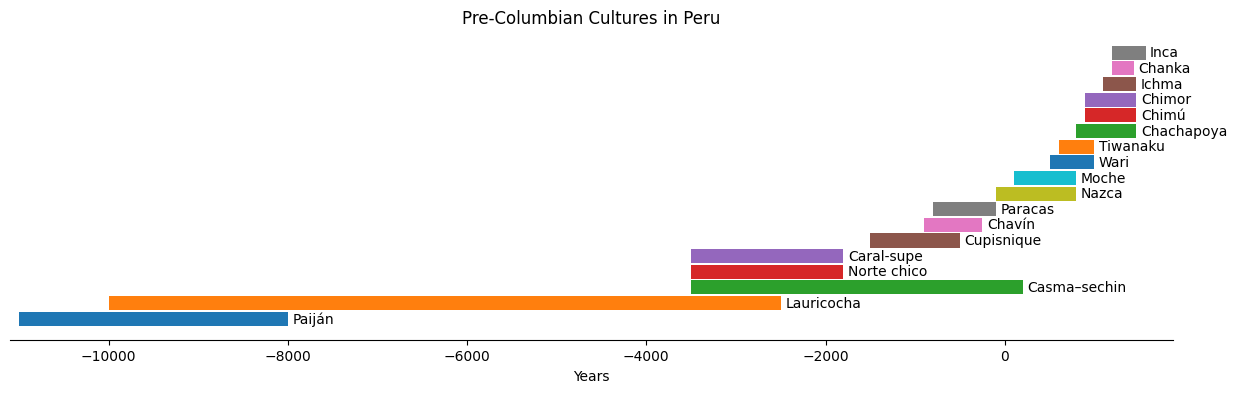

In [9]:
plot_cultures_timelines(CulturesPeru, title='Pre-Columbian Cultures in Peru')

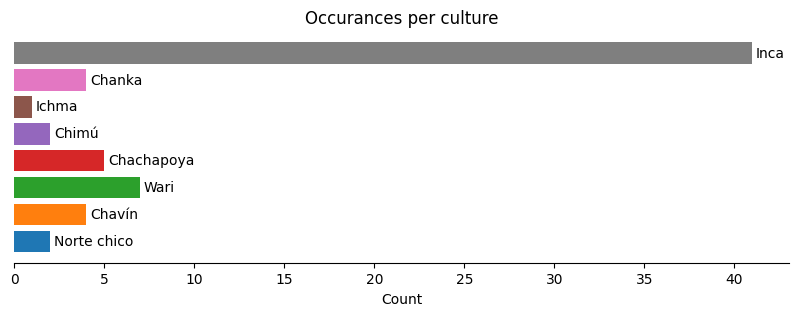

In [10]:
encountered_cultures = {}
for key in CulturesPeru.keys():
    encountered_cultures[key] = 0
for key in cultures.keys():
    for key1 in encountered_cultures.keys():
        if key1 in key:
            encountered_cultures[key1] += cultures[key]
            break
            
fig, ax = plt.subplots(figsize=(10,3))
i = 0
for key in encountered_cultures:
    if encountered_cultures[key] > 0:
        i += 1
        plt.barh(i, width = encountered_cultures[key])
        plt.text(encountered_cultures[key]+0.2, i, key.capitalize(), va='center')  # adjust `+10` as needed for spacing
ax.spines[['right', 'top', 'left']].set_visible(False)
plt.yticks([])
plt.xlabel('Count')
plt.title("Occurances per culture")
plt.show()

Now using this info, I visit extracted data, and for those that have specified culture, but not dates. I will use these years as estimates of foundation and abandonment. 

In [11]:
def culture_based_foundation(data:dict, CulturesDict:dict) ->tuple[dict, bool]:
    """
    Based on the culture the settlement beloged to, assigns correpsonding foundation and abandonment dates.
    
    -------
    :param data: Dictionary containing main data about the settlment
    :param CulturesDict: Dictionary with culture names as keys and touple of their starting and ending year, as a value.

    -------
    :returns: updated data dictionary, and a flag indicating if any edits were made
    """
    if 'CULTURE' in data.keys():
        for culture in CulturesDict.keys():
            if culture in data['CULTURE']:
                if 'FOUNDED NUMERIC' not in data.keys():
                    data['FOUNDED NUMERIC'] = CulturesDict[culture][0]
                if 'ABANDONED NUMERIC' not in data.keys():
                    data['ABANDONED NUMERIC'] = CulturesDict[culture][1]
                if 'TEXT' in data.keys():
                    data.pop('TEXT')
            return data, True
    return data, False

In [12]:
complete_years, edited_years, missing_years = 0, 0, 0
for i, data in enumerate(all_data):
    if 'FOUNDED NUMERIC' in data and 'ABANDONED NUMERIC' in data:
        complete_years += 1
    else:
        data, flag = culture_based_foundation(data, CulturesPeru)
        if flag:
            complete_years += 1
            edited_years += 1
        else:
            missing_years += 1
    all_data[i] = data
print(f"Number of sites with complete start and end dates: {complete_years}")
print(f"Number of sites with start and end dates edited based on their culture: {edited_years}")
print(f"Number of sites with missing start or end dates: {missing_years}")

Number of sites with complete start and end dates: 86
Number of sites with start and end dates edited based on their culture: 52
Number of sites with missing start or end dates: 144


## Graphs!

It is finally time to show this data on a map. Below we see the distribution of the encountered sites in space, and also in time.

Most of the foundation years are after 2000 BC.

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

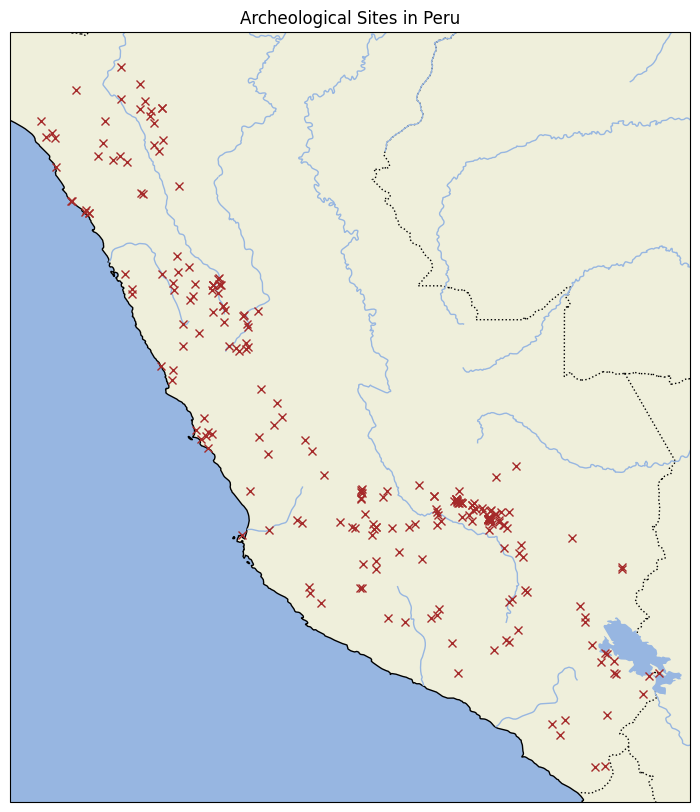

In [13]:
# Set up a basic map
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

# Plot points
all_foundation_dates = []
for data in all_data:
    lat, lon = data['LATITUDE'], data['LONGITUDE']
    ax.plot(lon, lat, marker='x', color='brown', transform=ccrs.Geodetic())
    if 'FOUNDED NUMERIC' in data.keys():
        all_foundation_dates.append(data['FOUNDED NUMERIC'])

plt.title('Archeological Sites in Peru')
plt.show()

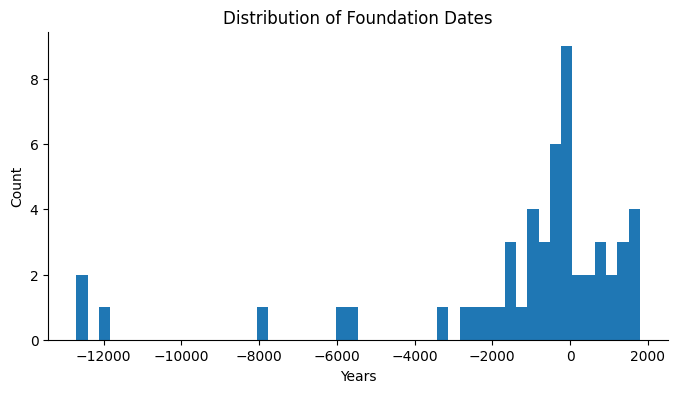

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
ax.spines[['right', 'top']].set_visible(False)
plt.hist(all_foundation_dates,bins=50)
plt.title("Distribution of Foundation Dates")
plt.ylabel('Count')
plt.xlabel('Years')
plt.show()

### Create Actual Dynamic Graphs

Now with all this nice data, we want to build an adjacency matrix, connecting the nearby sites.
Additionally, we observe points in time and select subsets of all the nodes that were 'active' at the time. Since most of the time prior 2000 BC we don't have many changes, the timestamps in that period will be sparser, and posterior ones will be danser (and we will use 1500 AD as the end date, since that is already post-Columbian period).

In [15]:
def build_adjecency_matrix(all_data:list, all_foundation_dates:list, timestamps:list, distance_threshold:int, plot_flag:bool=True):
    """
    Computes adjecency matrix based on world-distances between sites. 
    Further, creates a matrix of age based occurences of sites, so taht at any given timestamp we can which were the cities that were active.

    
    -------
    :param all_data: List of dictionaries containing main data about the settlment
    :param all_foundation_dates: List of foundation years (numeric) for the correpsonding settlemtns
    :param timestamps: List of timestamps/years for which we check eistance for the correpsonding settlemtns
    :param distance_threshold: Threshold value for the straight-line distance between two setlmenets (in kilometers) to consider them connected 
    :param plot_flag: If set to True, plots the extracted things

    -------
    :returns: ajdacency matrix for hte settlements graph, matrix of temporal occurances for each settlemnt and their geo locations (latitude and longitude)    
    """
    n= len(all_data)
    adjecency_matrix = np.zeros((n,n))
    locations_matrix = np.zeros((n,2))
    times_matrix = np.zeros((n,2)).astype(int)
    temporal_occurance_matrix = np.zeros((n, len(timestamps)))
    for i, data in enumerate(all_data):
        locations_matrix[i] += (data['LATITUDE'], data['LONGITUDE'])
        if 'FOUNDED NUMERIC' in data.keys():
            times_matrix[i,0] = data['FOUNDED NUMERIC']
        else:
            times_matrix[i,0] = min(all_foundation_dates)
        if 'ABANDONED NUMERIC' in data.keys():
            times_matrix[i,1] = data['ABANDONED NUMERIC']
        else:
            times_matrix[i,1] = 1500
        if times_matrix[i,1] < times_matrix[i,0]:
            times_matrix[i,0] = times_matrix[i,1]
            times_matrix[i,1] = 1500
    for i in range(n):
        for j in range(i,n):
            adjecency_matrix[i, j] = great_circle(locations_matrix[i], locations_matrix[j]).km
            adjecency_matrix[j, i] += adjecency_matrix[i,j]
        temporal_occurance = (times_matrix[i,0] <= np.array(timestamps))*(times_matrix[i,1] >= np.array(timestamps))*1
        temporal_occurance_matrix[i] += temporal_occurance

    if plot_flag:
        distance_matrix = adjecency_matrix.copy()
        distance_matrix[distance_matrix==0] = adjecency_matrix.max()
        distance_vector = distance_matrix.min(1)
        fig, ax = plt.subplots(figsize=(12,4))
        ax.spines[['right', 'top']].set_visible(False)
        plt.hist(distance_vector,bins=230,color='g')
        plt.title("Histogram of pair-wise site distances")
        plt.ylabel("count")
        plt.xlabel("Distances in km")
        plt.scatter(distance_threshold,0,color='yellow',marker='d',s=100)
        plt.show()
    
    adjecency_matrix[adjecency_matrix <= distance_threshold]=1
    adjecency_matrix[adjecency_matrix > distance_threshold]=0
    adjecency_matrix -= np.eye(n)
    if plot_flag:
        fig, ax = plt.subplots(figsize=(7,7))
        order = np.argsort(np.mean(adjecency_matrix,1))
        adjecency_matrix_sorted = adjecency_matrix[order]
        adjecency_matrix_sorted = adjecency_matrix_sorted[:,order]
        plt.imshow(adjecency_matrix_sorted, cmap='binary')
        ax.spines[['right', 'top','left','bottom']].set_visible(False)
        plt.title("Adjecency matrix")
        plt.xticks([])
        plt.yticks([])
        plt.show()
    
        fig, ax = plt.subplots(figsize=(7,7))
        plt.imshow(temporal_occurance_matrix[order], cmap='binary')
        plt.title("Temporal occurances matrix")
        ax.spines[['right', 'top','left','bottom']].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Time')
        plt.ylabel('Sites')
        plt.show()

    return adjecency_matrix, temporal_occurance_matrix.astype(int), locations_matrix


Below we can see informative plots about our nodes/settlements. The barplot shows the distances between the nearest neighbors/settlements, in kilometers (straight line). Yellow triangle shows a selected distance threshold -- the nodes at a distance of 100km or less are considered to be directly connected, to avoid having isolated nodes.
 
Under that, we have an adjacency matrix, inferred from this distance threshold (and sorted accordingly). Black pixels indicate that there is a connection between the nodes of the graph.
FInally, the last plot is a temporal occurrence matrix. There, each row corresponds to a single settlement, and each column to a year from the timestamps list (we defined it in the next cell). Thite pixels there indicate that the observed settlement didn't exist (or wasn't inhabited) at that time.

Time stamps: [-12700, -11677, -10655, -9633, -8611, -7588, -6566, -5544, -4522, -3500, -3250, -3055, -2861, -2666, -2472, -2277, -2083, -1888, -1694, -1500, -1400, -1300, -1200, -1100, -1000, -900, -800, -700, -600, -500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]



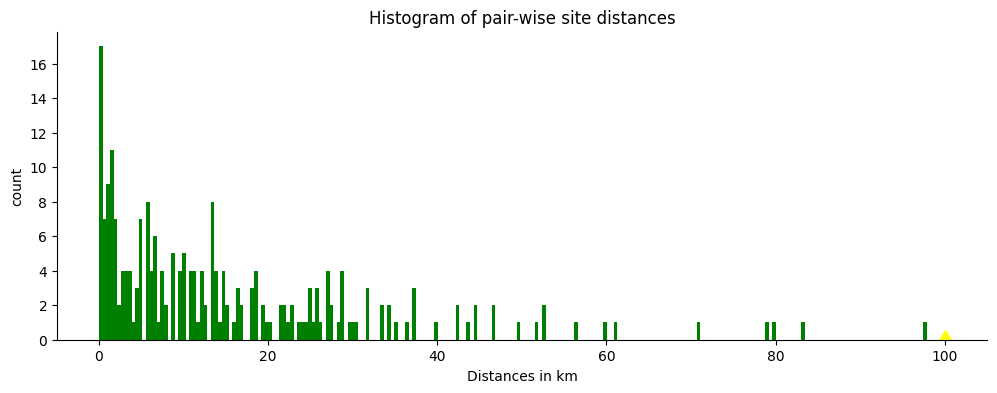

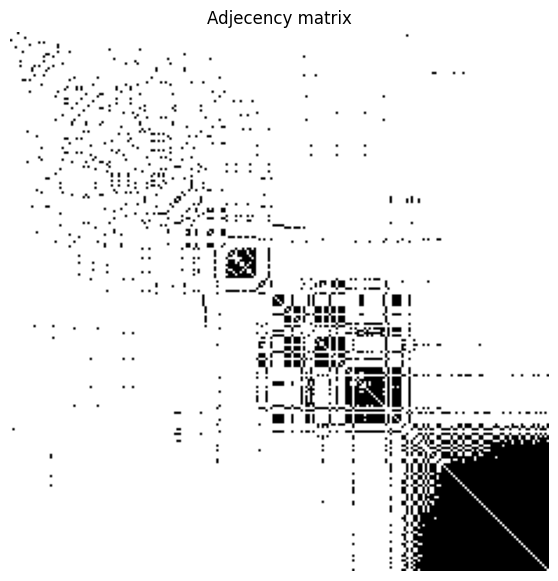

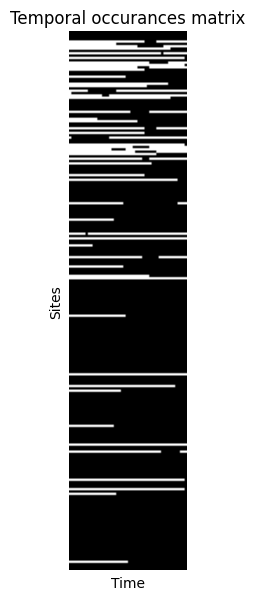

In [16]:
distance_threshold = 100
timestamps = np.linspace(min(all_foundation_dates), -3500, 10).tolist() + np.linspace(-3250, -1500, 10).tolist()+ np.linspace(-1400, 1500, 30).tolist()
timestamps = [int(t) for t in timestamps]
print(f"Time stamps: {timestamps}\n")
adjecency_matrix, temporal_occurance_matrix, locations_matrix = build_adjecency_matrix(all_data, all_foundation_dates, timestamps, distance_threshold)
np.save('Peru_adjecency_matrix.npy',adjecency_matrix)
np.save('Peru_temporal_occurance_matrix.npy',temporal_occurance_matrix)
np.save('Peru_locations_matrix.npy',locations_matrix)


Now let's look at the progression of the settlements over time.

Below GIF shows settlements by year, and edges shows which settlement pairs are considered neighbors. 

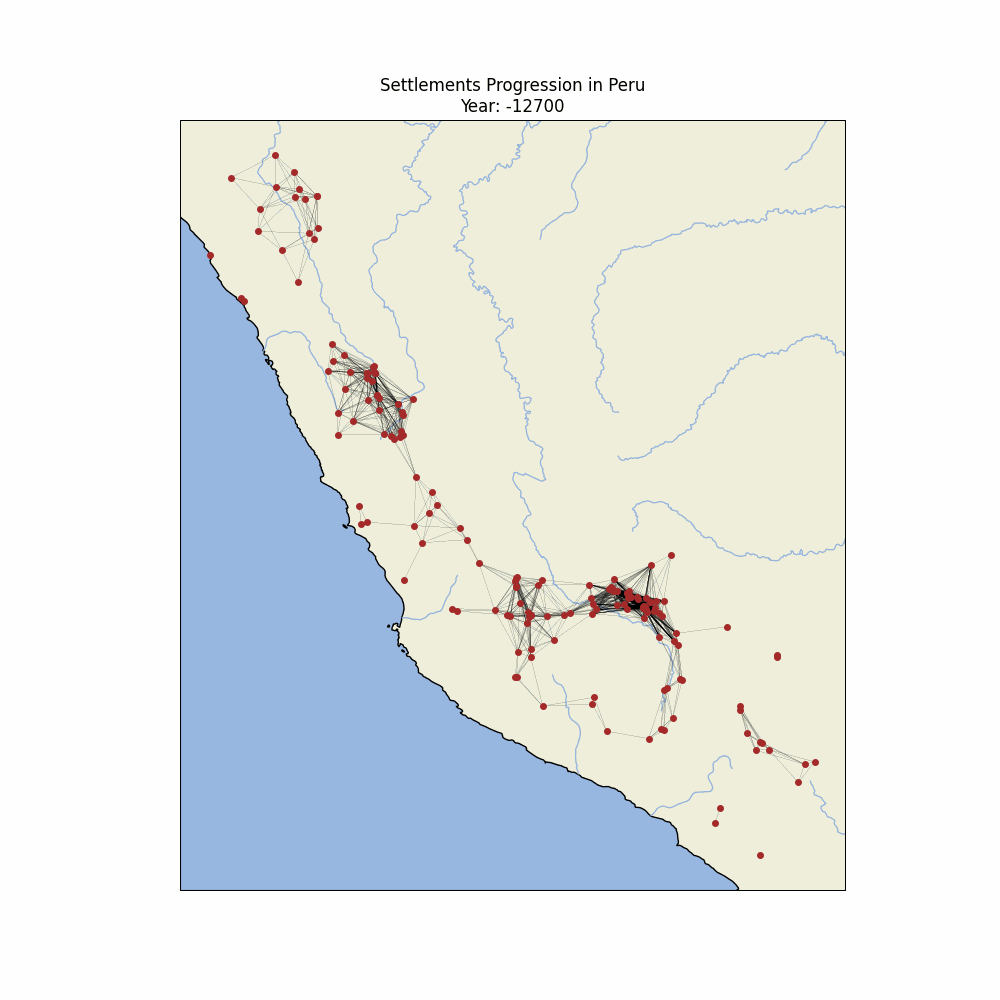

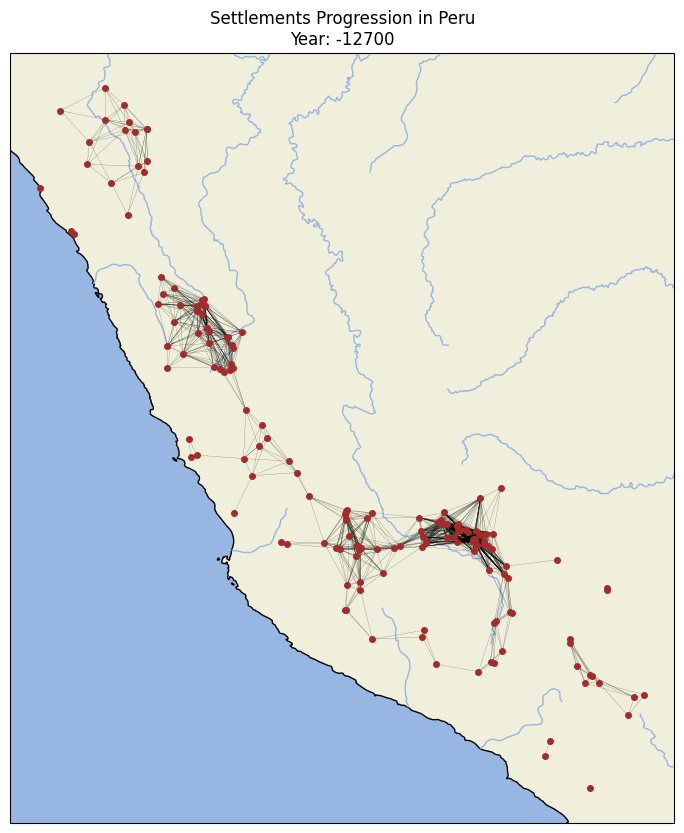

In [17]:
graph =nx.from_numpy_array(adjecency_matrix)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.OCEAN)
pos = {i: (locations_matrix[i][1], locations_matrix[i][0]) for i in range(len(locations_matrix))}  # (lon, lat)

def update(t):
    ax.clear()
    # Redraw static map features each frame
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.OCEAN)
    
    t_indices = np.where(temporal_occurance_matrix[:, t])[0]
    t_graph = graph.subgraph(t_indices).copy()

    # Plot edges manually
    for u, v in t_graph.edges():
        x_coords = [pos[u][0], pos[v][0]]
        y_coords = [pos[u][1], pos[v][1]]
        ax.plot(x_coords, y_coords, transform=ccrs.Geodetic(), color='k', linewidth=0.1)
    
    # Plot nodes
    for node in t_graph.nodes():
        lon, lat = pos[node]
        ax.plot(lon, lat, marker='o', color='brown', transform=ccrs.Geodetic(), markersize=4)

    ax.set_title(f"Settlements Progression in Peru\nYear: {int(timestamps[t])}", fontsize=12)

# Animate and save
anim = FuncAnimation(fig, update, frames=10, interval=600)
anim.save("temporal_graph_map.gif", writer=PillowWriter(fps=2))

# Display in notebook
Image(filename="temporal_graph_map.gif")


Nice! Shame we don't see the mountains info here, to conclude if these patterns of the graph are related to the elevation level (probably yes). Some things to notice here is that most of the settlements are near the water, either the river or the ocean coast, as was to be expected. Now, one idea to use these graphs is to build a regression model that predicts if at any time stamp a graph node in the graph will obtain a new neighbor or lose one of the existing ones. This could give us a clue as to where the potential lost cities could be.

# Future Work

This is incomplete work, and demands additional effort. I will keep on in a separate notebook. Besides the obvious need to incorporate other regions than Peru, there are a few more important directions to explore here.

For details on this, check my next notebook [Walking Through the Hills](https://www.kaggle.com/code/rackovic1994/walking-through-the-hills)

## 1. Distances
Straight line is not a good distance measure. Especially in the ancient times. And especially in the mountain region like Peru. Distances should incorporate the info of elevation levels and rivers.

## 2. Incorporating GPT
As mentioned earlier in this notebook, i didn't use any, because i am cheap. But it would be a good assistant in determining the foundation dates, when they are not clearly stated in the info-box or intro.

## 3. Node Features
Clearly the nodes are not scattered randomly. Hills and river proximity are important. To account for this, I think the nodes should have features such as geographical altitude, and a river proximity. But for river proximity I wouldn't use straight line distance. Instead, I advocate for using a relief map, and flooding method. Seeing at which altitude of the water does the distance to the settlement significantly (and sufficiently) drop.

## 4. Build a regression model
This is still to figure out, but the idea for now is to train a simple medel, even something like linear regression. An input would be a single node, with its features like the ones mentioned above, but also with its graph-derived features, that will change with time (degree, centrality,...). The output would be as simple as the number of neighbors to expect. Then, when a model is good enough, we can see the nodes where it 'fails', and they would be potential locations for the lost cities. 